In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import cross_val_score

from scipy import stats
import seaborn as sns
from copy import deepcopy

%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.shape

(188318, 132)

In [4]:
print("First 20 columns:",list(train.columns[:20]))
print("First 20 columns:",list(train.columns[-20:]))

First 20 columns: ['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19']
First 20 columns: ['cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss']


In [5]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


数据已经经过预处理缩放到0，1区间内了

In [6]:
train.isnull().any().value_counts()

False    132
dtype: int64

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [8]:
cat_features = list(train.select_dtypes(include=['object']).columns)
print(f"离散特征Categorical:{len(cat_features)} features")

离散特征Categorical:116 features


In [9]:
cont_features = [cont for cont in list(train.select_dtypes(include=['float64','int64'])) if cont not in ['loss','id']]
print('连续特征Continuous: {} features'.format(len(cont_features)))

连续特征Continuous: 14 features


In [10]:
id_col = list(train.select_dtypes(include=['int64']))
print(f'A column of int64:{id_col}')

A column of int64:['id']


### 类别值中属性的个数

In [11]:
#统计类别属性中不同类别的个数
cat_uniques=[]
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
uniq_values_in_categories = pd.DataFrame.from_dict({'cat_name':cat_features,'unique_values':cat_uniques})
uniq_values_in_categories

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2
...,...,...
111,cat112,51
112,cat113,61
113,cat114,19
114,cat115,23


Text(7, 71, 'Binary features')

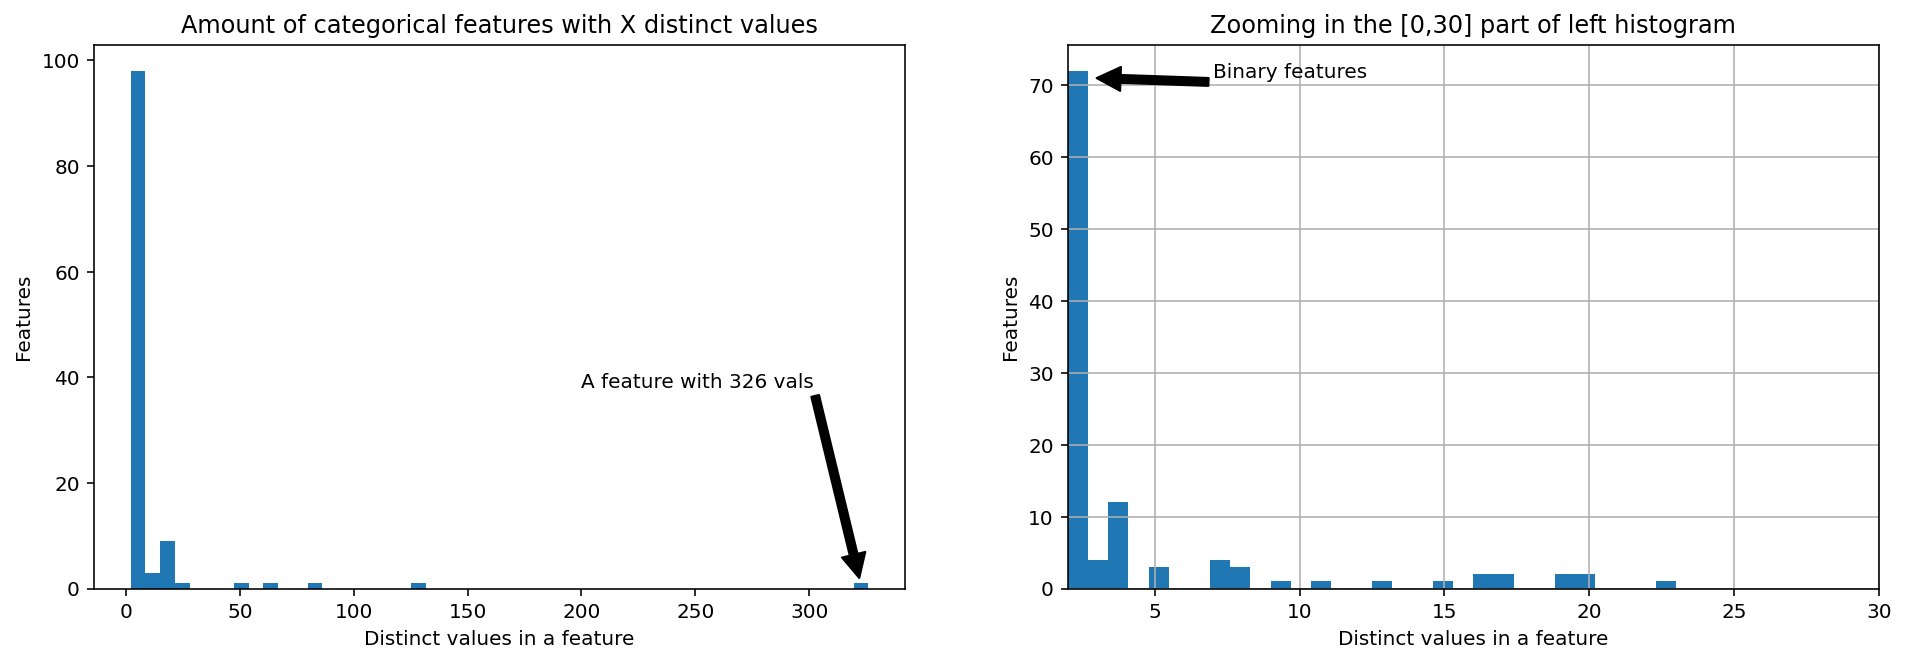

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)

ax1.hist(uniq_values_in_categories.unique_values,bins=50)
ax1.set_title("Amount of categorical features with X distinct values")
ax1.set_xlabel("Distinct values in a feature")
ax1.set_ylabel("Features")
ax1.annotate('A feature with 326 vals',
             xy=(322,2),xytext=(200,38),
            arrowprops=dict(facecolor='black'))

ax2.set_xlim(2,30)
ax2.set_title("Zooming in the [0,30] part of left histogram")
ax2.set_xlabel("Distinct values in a feature")
ax2.set_ylabel("Features")
ax2.grid(True)
ax2.hist(uniq_values_in_categories[uniq_values_in_categories.unique_values<=30].unique_values,bins=30)
ax2.annotate('Binary features', xy=(3, 71), xytext=(7, 71), arrowprops=dict(facecolor='black'))

### 赔偿值

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


train['id']个数: 188318


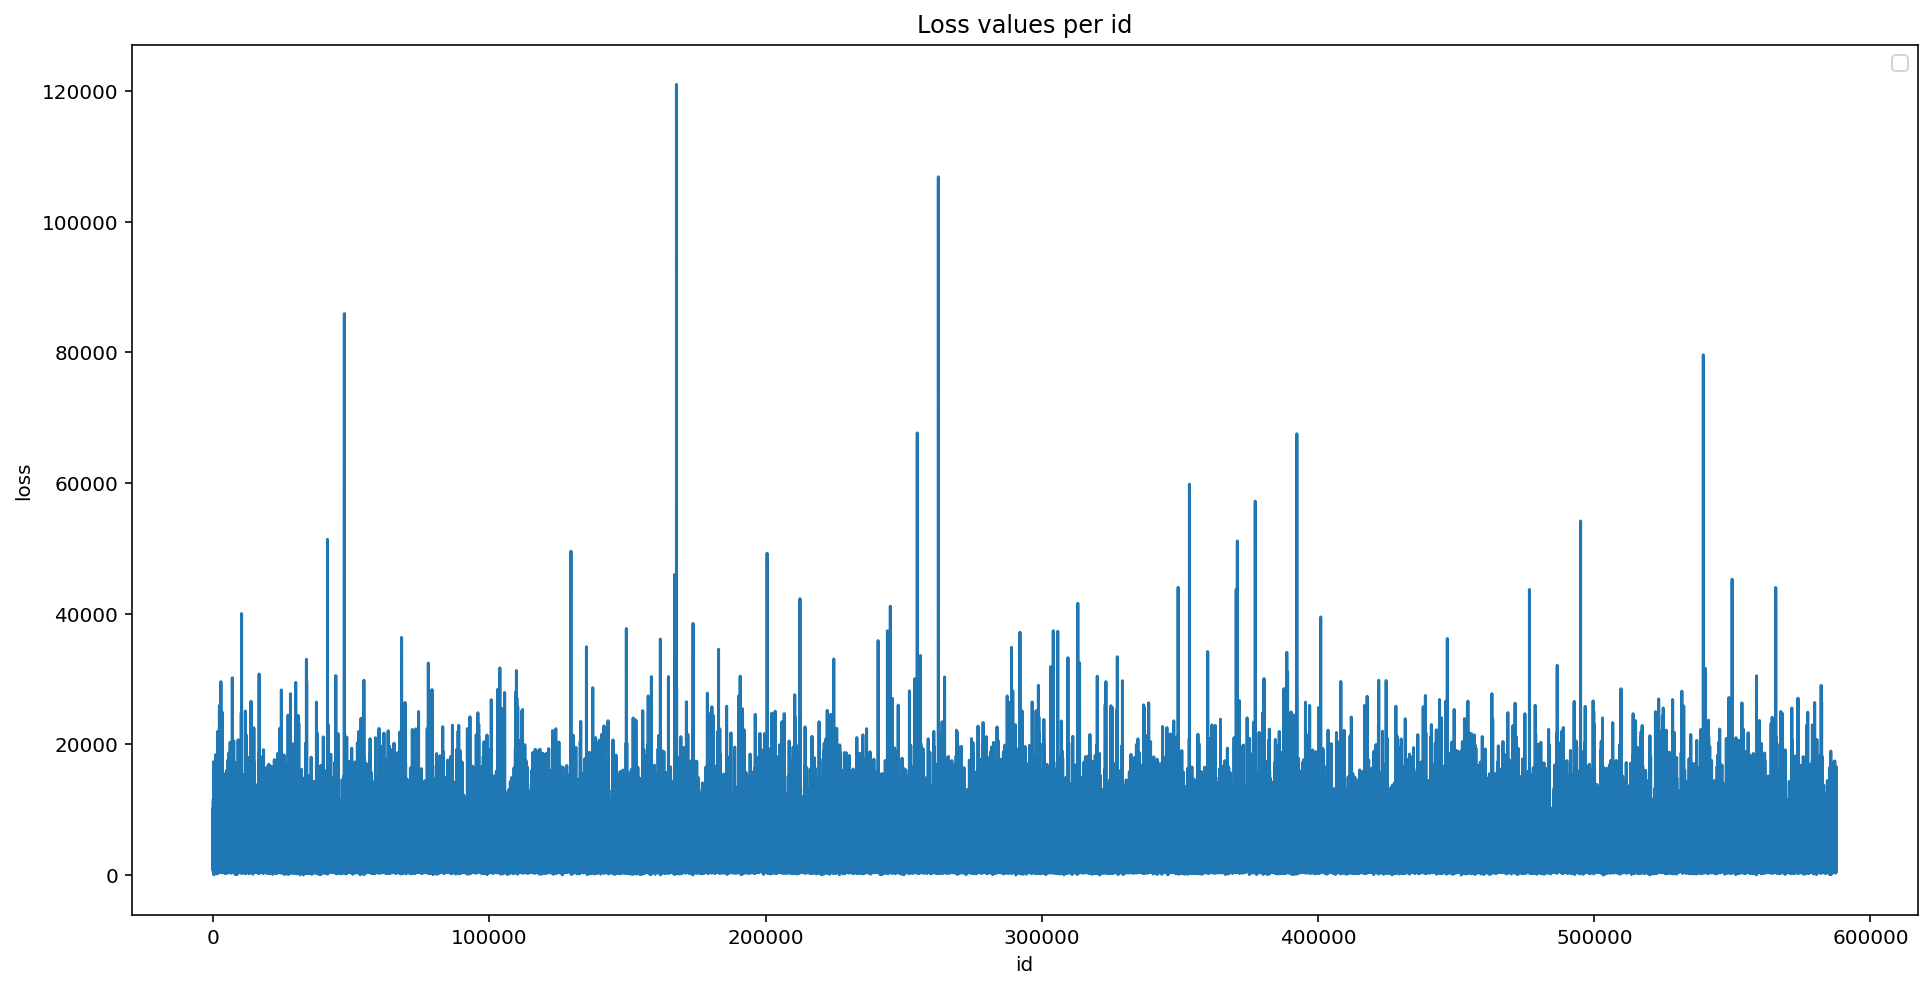

In [13]:
plt.figure(figsize=(16,8))
plt.plot(train['id'],train['loss'])
print('train[\'id\']个数:',len(train['id']))
plt.title("Loss values per id")
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()

In [14]:
#scipy.stats 统计指标
stats.mstats.skew(train['loss']).data

array(3.79492815)

In [15]:
stats.mstats.skew(train['loss'])

masked_array(data=3.79492815,
             mask=False,
       fill_value=1e+20)

偏度大于1说明数据倾斜不利于建模，所以对数据变换np.log降低skew

In [16]:
stats.mstats.skew(np.log(train['loss'])).data

array(0.0929738)

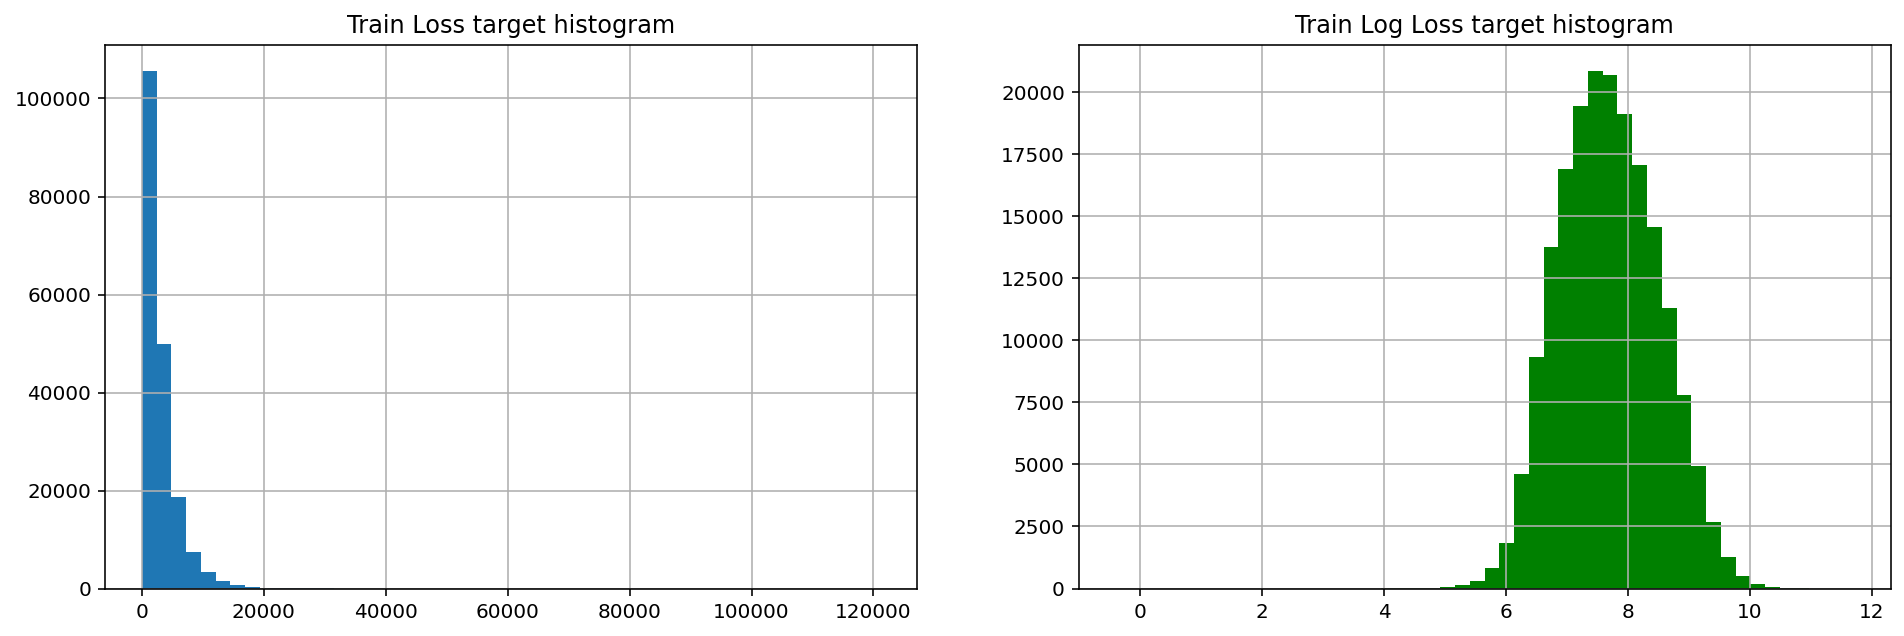

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'],bins=50)
ax1.set_title("Train Loss target histogram")
ax1.grid(True)

ax2.hist(np.log(train['loss']),bins=50,color='g')
ax2.set_title("Train Log Loss target histogram")
ax2.grid(True)
plt.show()

### 连续值特征

array([[<AxesSubplot:title={'center':'cont1'}>,
        <AxesSubplot:title={'center':'cont2'}>,
        <AxesSubplot:title={'center':'cont3'}>,
        <AxesSubplot:title={'center':'cont4'}>],
       [<AxesSubplot:title={'center':'cont5'}>,
        <AxesSubplot:title={'center':'cont6'}>,
        <AxesSubplot:title={'center':'cont7'}>,
        <AxesSubplot:title={'center':'cont8'}>],
       [<AxesSubplot:title={'center':'cont9'}>,
        <AxesSubplot:title={'center':'cont10'}>,
        <AxesSubplot:title={'center':'cont11'}>,
        <AxesSubplot:title={'center':'cont12'}>],
       [<AxesSubplot:title={'center':'cont13'}>,
        <AxesSubplot:title={'center':'cont14'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

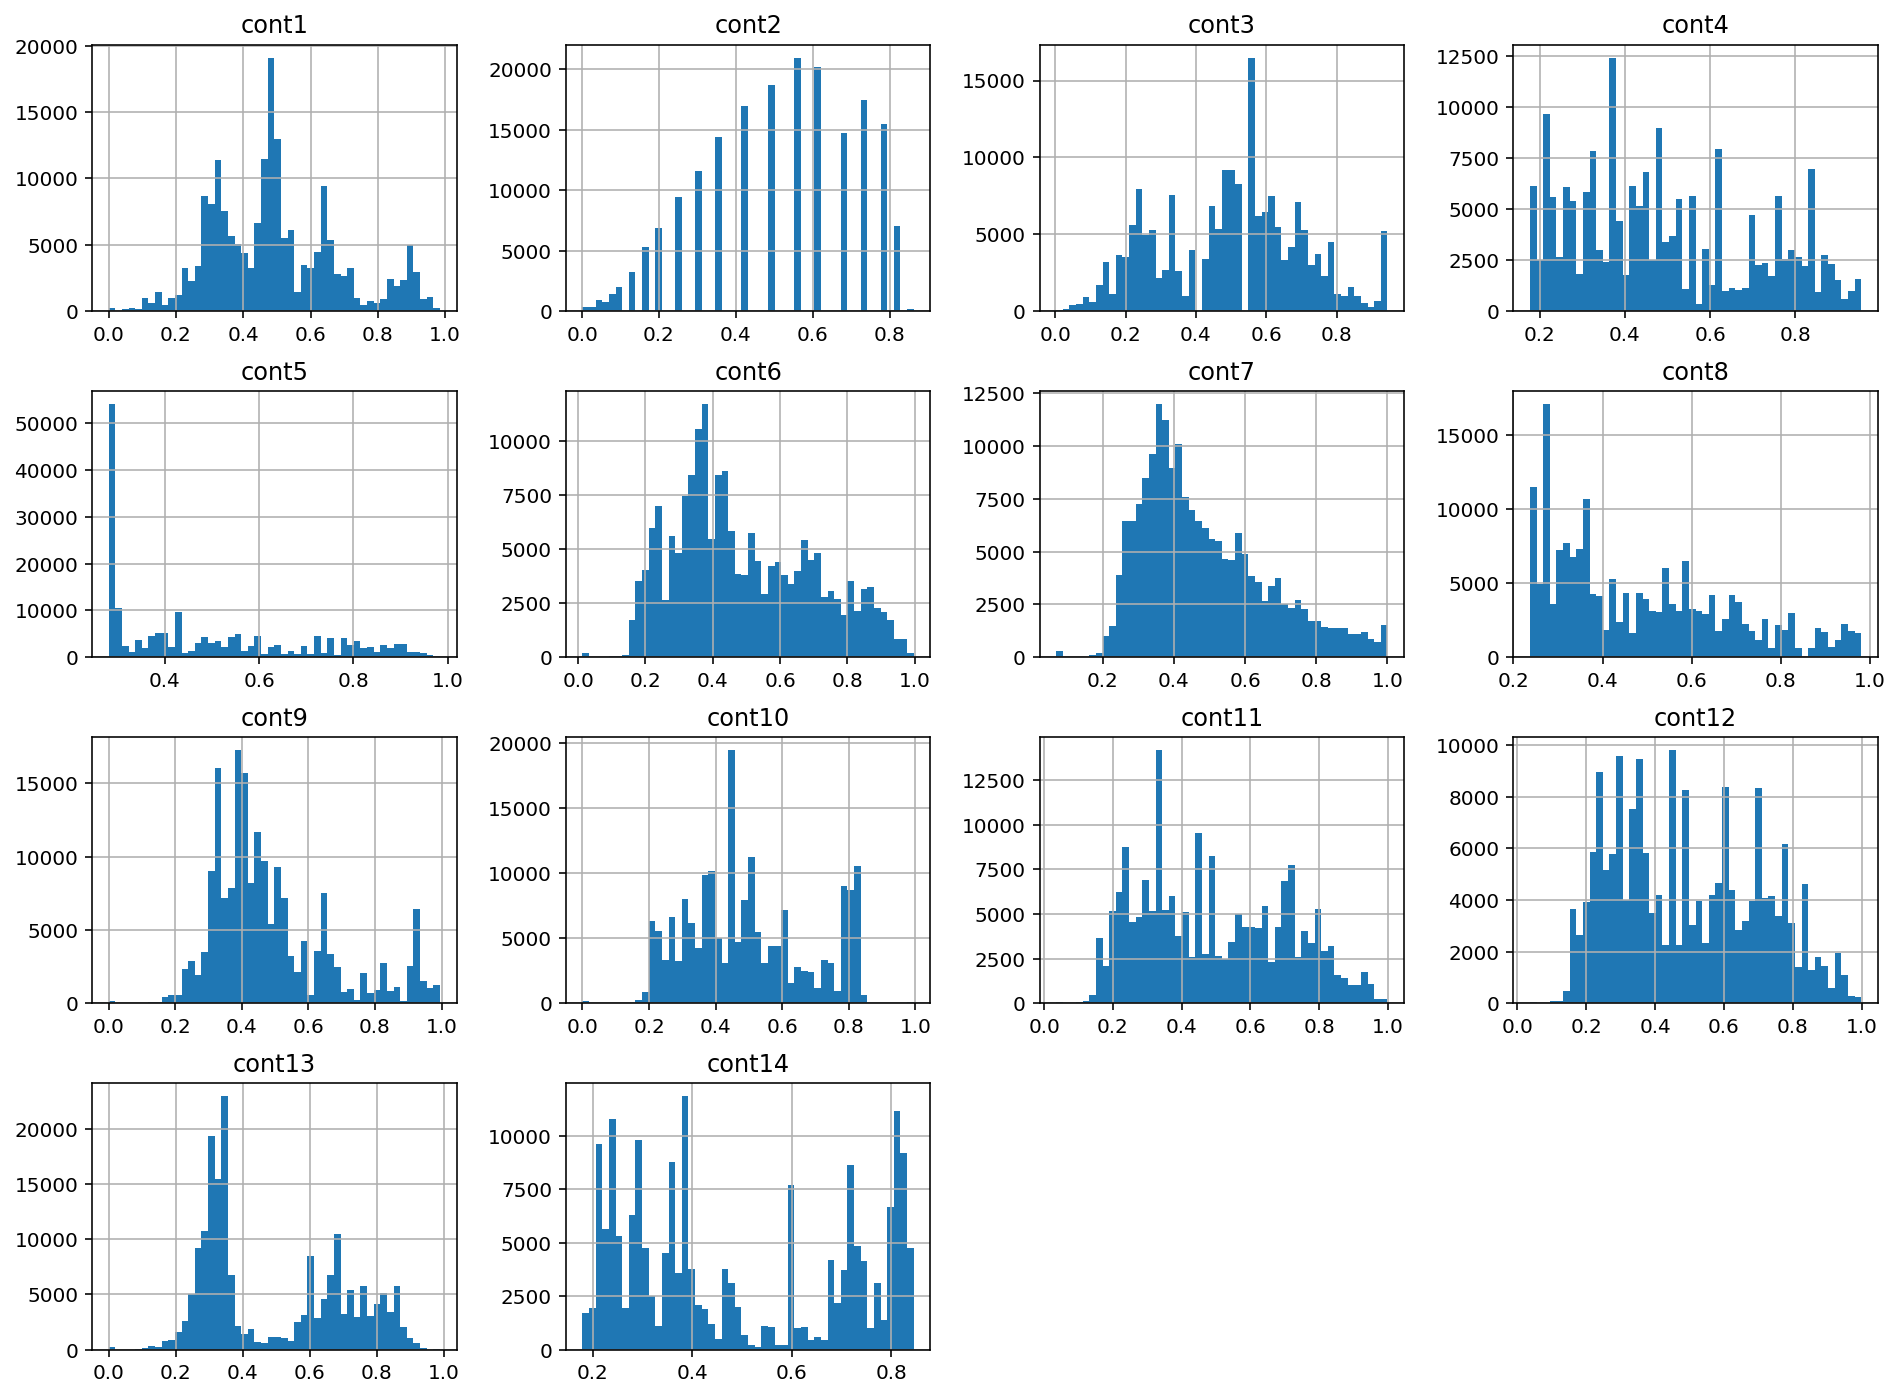

In [18]:
train[cont_features].hist(bins=50,figsize=(16,12))

<AxesSubplot:>

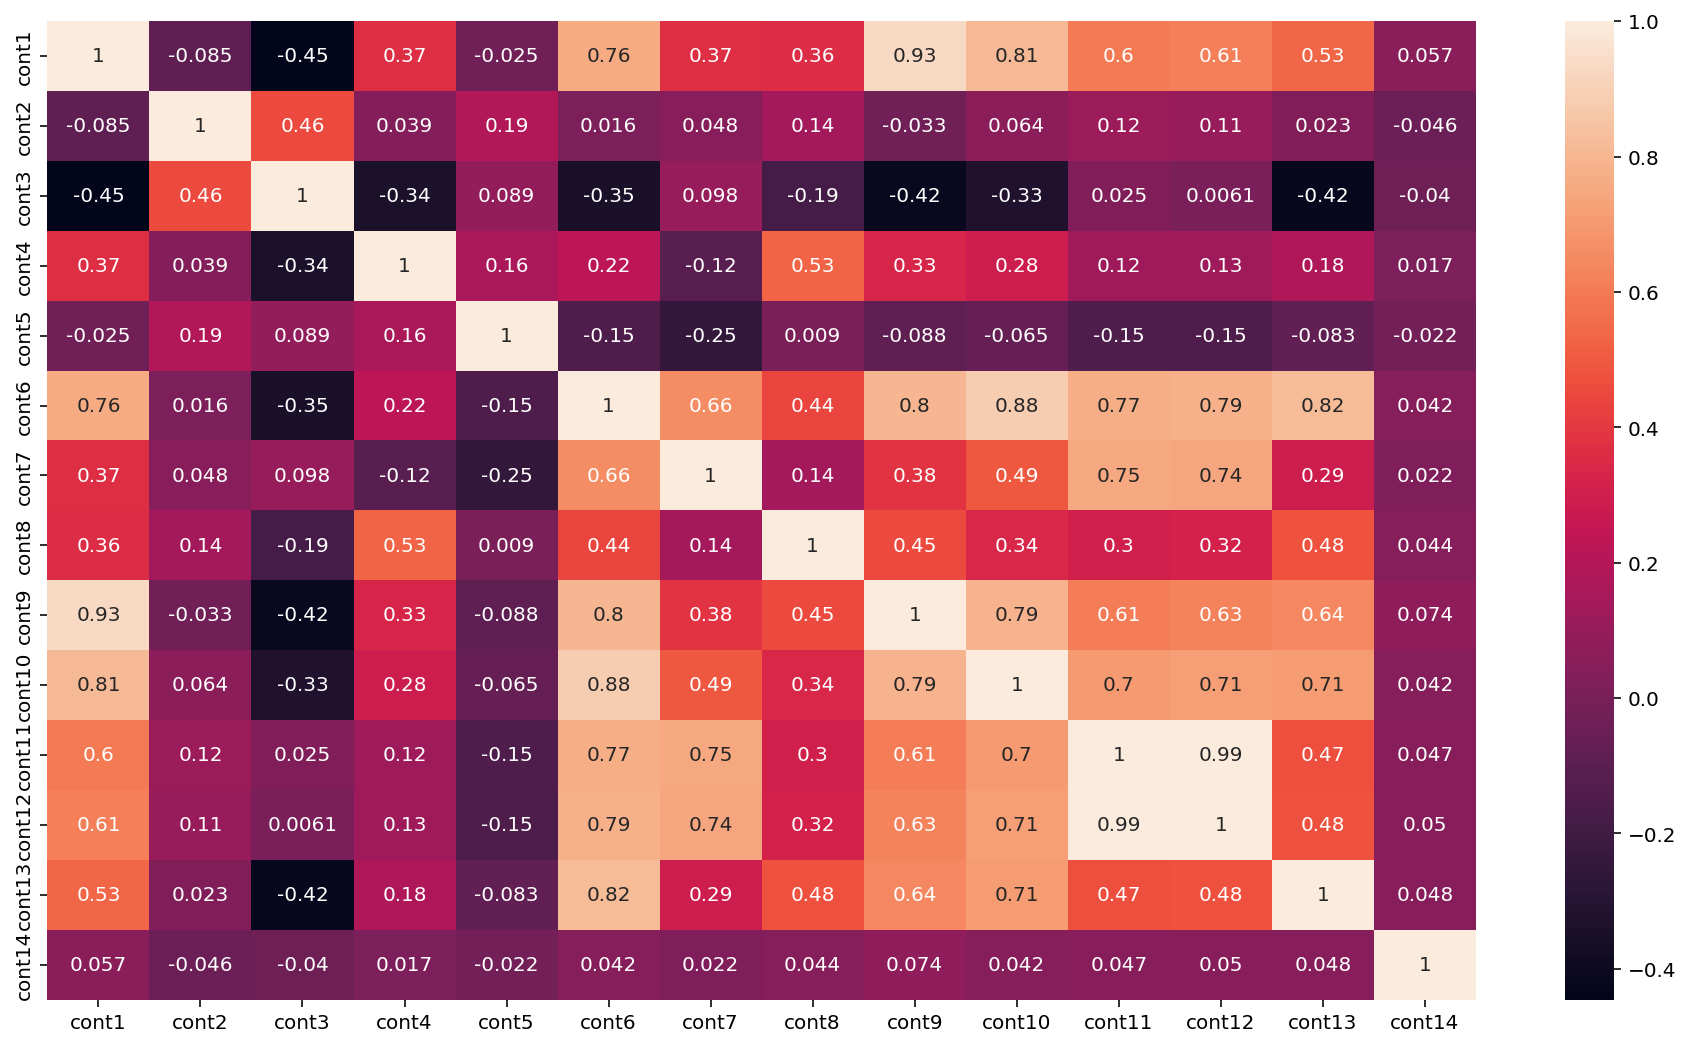

In [19]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat,annot=True)

### xgboost调参

In [20]:
import xgboost as xgb
import pickle
import sys
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.sparse import csr_matrix,hstack
from sklearn.model_selection import KFold,train_test_split
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [21]:
train['log_loss'] = np.log(train['loss'])

In [22]:
train.head(3)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,log_loss
0,1,A,B,A,B,A,A,A,A,B,...,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18,7.702186
1,2,A,B,A,A,A,A,A,A,B,...,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60,7.157424
2,5,A,B,A,A,B,A,A,A,B,...,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09,8.008063


In [23]:
features = [x for x in train.columns if x not in ['id','loss','log_loss']]

cat_features = [x for x in train.select_dtypes(
            include=['object']).columns if x not in ['id','loss','log_loss']]
num_features = [x for x in train.select_dtypes(
            exclude=['object']).columns if x not in ['id','loss','log_loss']]
print("Categorical features:",len(cat_features))
print("Numerical features:",len(num_features))

Categorical features: 116
Numerical features: 14


In [24]:
ntrain = train.shape[0]
train_x = train[features]
train_y = train['log_loss']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
print("Xtrain:",train_x.shape)
print("ytrain:",train_y.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


# 开始训练xgboost模型

通过交叉验证调节参数，使用MAE来衡量误差

xgboost自定义了一个数据矩阵类DMatrix会在训练开始时进行一边预处理，从而提高之后每次迭代的效率

In [25]:
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'MAE',mean_absolute_error(np.exp(y),np.exp(yhat))

### model

In [26]:
dtrain = xgb.DMatrix(train_x,train['log_loss'])#提升效率，用dtrain表示x和y

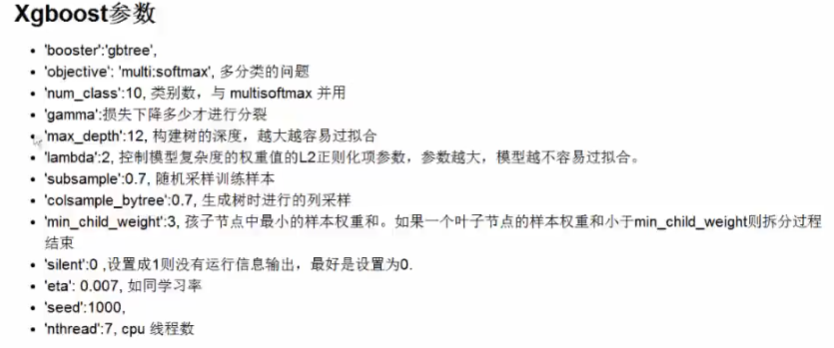

这边我是提供了一个比较经验的参数字典，目的是直接用这个参数建立xgboost模型看效果怎么样可以作为参考值

In [27]:
xgb_params = {
    'seed':0,
    'eta':0.1,
    'colsample_bytree':0.5,
    'silent':1,
    'subsample':0.5,
    'objective':'reg:linear',
    'max_depth':5,
    'min_child_weight':3
}

使用交叉验证xgb.cv

In [28]:
%%time

bst_cv1 = xgb.cv(xgb_params,dtrain,num_boost_round=50,nfold=3,seed=0,
                feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)

[20:06:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

In [29]:
bst_cv1

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-MAE-mean,train-MAE-std,test-MAE-mean,test-MAE-std
0,6.514311,0.002191,6.514302,0.005065,3033.952311,8.528549,3033.952311,17.058441
1,5.869835,0.002107,5.869851,0.005002,3030.857178,8.526992,3030.856852,17.058344
2,5.290480,0.002105,5.290447,0.004909,3025.697591,8.528159,3025.696777,17.053735
3,4.769721,0.001622,4.769829,0.005285,3017.590739,8.525742,3017.591878,17.049824
4,4.301770,0.001411,4.301910,0.005344,3005.536051,8.516956,3005.539388,17.045843
5,3.881480,0.001321,3.881601,0.005311,2988.447591,8.503692,2988.451660,17.037882
6,3.504095,0.001242,3.504159,0.005233,2965.277018,8.489338,2965.279948,17.016933
7,3.165429,0.001054,3.165522,0.005241,2935.101156,8.440721,2935.107422,17.006412
8,2.861772,0.000705,2.861924,0.005543,2897.307373,8.346562,2897.325765,17.039231
9,2.589610,0.000370,2.589853,0.005845,2851.267985,8.181709,2851.305176,17.112639


In [30]:
print("CV score:",bst_cv1.iloc[-1,:]['test-MAE-mean'])

CV score: 1220.1099853333333


所以这边可以看出我们得到了一个MAE的基准结果，即MAE = 1220.1

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

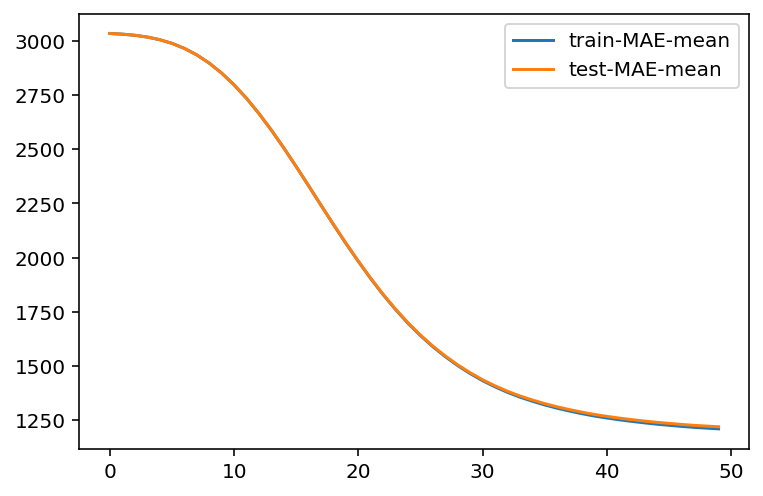

In [31]:
plt.figure()
bst_cv1[['train-MAE-mean','test-MAE-mean']].plot()

In [32]:
%%time
#改成100棵树，即num_boost_round=100

bst_cv2 = xgb.cv(xgb_params,dtrain,num_boost_round=100,nfold=3,seed=0,
                feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)
print("CV score:",bst_cv2.iloc[-1,:]['test-MAE-mean'])

[20:06:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:06:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:06:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language binding

有一点点提升了，MAE从1220下降到了1172，但下降不多，所以没有必要再增加树的数量了因为时间会比较长而且过拟合风险会增加

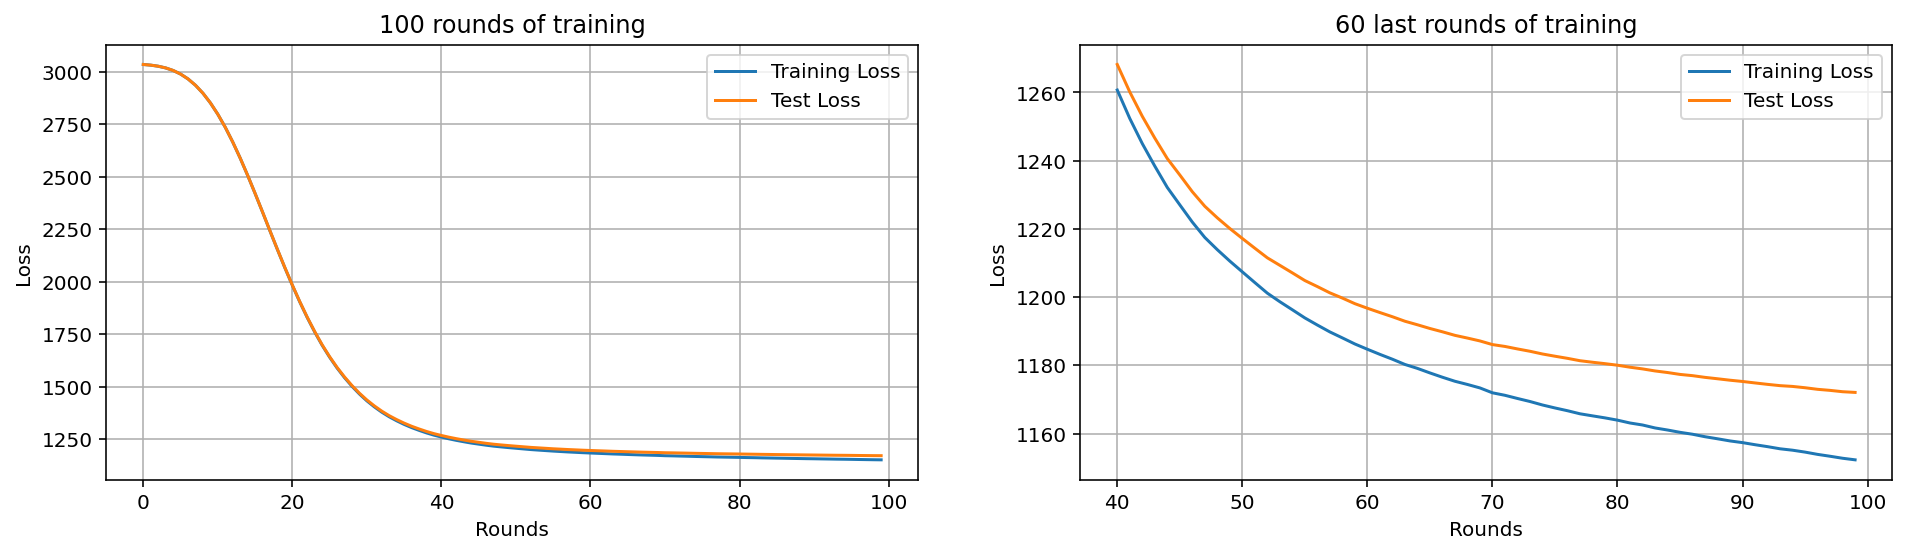

In [33]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title("100 rounds of training")
ax1.set_xlabel("Rounds")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.plot(bst_cv2[['train-MAE-mean','test-MAE-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title("60 last rounds of training")
ax2.set_xlabel("Rounds")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-MAE-mean','test-MAE-mean']])
ax2.legend(['Training Loss','Test Loss'])

有一点点过拟合了，目前没啥情况，所以100棵树目前还是稍微好一点的，要看看其他参数了

### XGBoost调参策略

1.选择一组初始参数

2.改变max_depth和min_child_weight

3.调节gamma降低模型过拟合风险

4.调节subsample和colsample_bytree改变数据采样策略

5.调节学习率eta

### 封装一个XGBoostRegressor，后面用起来方便点

In [34]:
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})#默认参数
        
    def fit(self, x_train, y_train):
        '''
        #数据类型转换,#用参数去训练xgboost模型
        '''
        dtrain = xgb.DMatrix(x_train, y_train) 
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self 


In [35]:
def mae_score(y_true,y_pred):
    return mean_absolute_error(np.exp(y_true),np.exp(y_pred))

mae_scorer = make_scorer(mae_score,greater_is_better = False)

In [36]:
bst = XGBoostRegressor(eta=0.1,colsample_bytree=0.5,subsample=0.5,max_depth=5,min_child_weight=3,num_boost_round=50)

In [37]:
bst.kfold(train_x,train_y,nfold=5)

[20:07:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

train-rmse-mean       0.558938
train-rmse-std        0.001005
test-rmse-mean        0.562665
test-rmse-std         0.002445
train-MAE-mean     1209.707324
train-MAE-std         3.004207
test-MAE-mean      1218.884204
test-MAE-std          8.982969
Name: 49, dtype: float64

## 看树的深度与节点权重

min_child_weight:正则化参数，如果树分区中的实例权重小于定义的综合，则停止树的构建过程

In [38]:
xgb_param_grid = {'max_depth':list(range(4,9)),'min_child_weight':list((1,3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7, 8]

In [39]:
%%time

grid = GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,colsample_bytree=0.5,subsample=0.5),
                   param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

[20:07:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:07:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:07:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:08:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:08:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:09:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:09:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:09:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:10:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:10:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:11:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:11:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:11:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:12:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:12:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:12:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:13:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:13:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:13:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:14:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:14:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:14:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:15:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:15:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:15:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBB0BE0>,
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 3, 6]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [40]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([2.37292533, 2.37244244, 2.37554073, 2.77222857, 2.76008539,
         2.75923095, 3.22746477, 3.27848673, 3.17847672, 3.68499036,
         3.66365986, 3.64068589, 4.30080605, 4.35416865, 4.44365749]),
  'std_fit_time': array([0.02301764, 0.02270953, 0.0162586 , 0.02496218, 0.01194233,
         0.00663411, 0.02743713, 0.13502388, 0.03620742, 0.03238086,
         0.02297574, 0.04272351, 0.05833112, 0.05214058, 0.08052752]),
  'mean_score_time': array([2.58033872, 2.54849644, 2.55707116, 3.06918249, 3.04931316,
         3.06424985, 3.64685717, 3.71644468, 3.59047718, 4.23540964,
         4.1715529 , 4.16683221, 5.04900627, 5.08326178, 5.13902116]),
  'std_score_time': array([0.06075749, 0.00632107, 0.0137054 , 0.01886789, 0.00693582,
         0.01266734, 0.03245979, 0.18728754, 0.01290017, 0.01429027,
         0.00737671, 0.01317421, 0.07976394, 0.07708352, 0.05447541]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8],
        

得到最好的参数{'max_depth': 8, 'min_child_weight': 6},
 -1187.5361330370838)

设置成负数是因为要找大的值

### 调节gamma降低过拟合风险

In [41]:
%%time

xgb_param_grid = {'gamma':[0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,max_depth=8,min_child_weight=6,
                                    colsample_bytree=0.5,subsample=0.5),
                   param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

[20:16:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:16:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:16:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:17:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:17:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:17:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:18:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:18:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:19:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:19:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBADF10>,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [42]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([4.32906446, 4.32609606, 4.33674545, 4.32514853, 4.48308153]),
  'std_fit_time': array([0.04793699, 0.04682715, 0.03564067, 0.03720806, 0.17930934]),
  'mean_score_time': array([5.06787086, 5.02156262, 5.01825571, 5.03708291, 5.16067452]),
  'std_score_time': array([0.05119112, 0.02800603, 0.02102402, 0.0672915 , 0.17838726]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.30000000000000004, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.30000000000000004},
   {'gamma': 0.4}],
  'split0_test_score': array([-1152.37494923, -1152.15803742, -1150.8176167 , -1152.59333276,
         -1151.61605937]),
  'split1_test_score': array([-1151.29905153, -1152.1645742 , -1150.06357642, -1151.6542982 ,
         -1151.26483554]),
  'split2_test_score': array([-1166.61301596, -1167.19343876, -1165.91394966, -1165.665165  ,

得到最佳gamma是0.1

In [43]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(6,9)],
                      'colsample_bytree':[ 0.1 * i for i in range(6,9)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(train_x, train_y.values)

[20:20:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:20:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:21:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:21:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:22:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:22:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:23:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:23:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:23:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:25:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:25:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:26:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:26:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:26:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:27:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:27:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBB03D0>,
             param_grid={'colsample_bytree': [0.6000000000000001,
                                              0.7000000000000001, 0.8],
                         'subsample': [0.6000000000000001, 0.7000000000000001,
                                       0.8]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [44]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([5.05619655, 4.63957095, 4.55420561, 5.2436595 , 5.1283371 ,
         5.02087097, 5.77137733, 5.61772041, 5.48780813]),
  'std_fit_time': array([0.36311475, 0.06019648, 0.05054436, 0.04389709, 0.04779081,
         0.04257355, 0.06054881, 0.03732054, 0.06429926]),
  'mean_score_time': array([5.921176  , 5.4105968 , 5.29758091, 6.1504488 , 6.04384675,
         5.9011323 , 6.83660002, 6.60858197, 6.44479008]),
  'std_score_time': array([0.43983411, 0.04052655, 0.04228228, 0.01235871, 0.02539498,
         0.00936075, 0.11493697, 0.02965551, 0.01556553]),
  'param_colsample_bytree': masked_array(data=[0.6000000000000001, 0.6000000000000001,
                     0.6000000000000001, 0.7000000000000001,
                     0.7000000000000001, 0.7000000000000001, 0.8, 0.8, 0.8],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array

得到{'colsample_bytree': 0.8, 'subsample': 0.8}

### 减小学习率并增大树的个数

参数优化的最后一步是降低学习速度同时增加更多的估计量

In [45]:
%%time
    
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values) 

[20:28:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:28:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:28:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:28:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:29:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:29:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:29:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:30:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:30:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:30:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:32:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:33:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:34:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:35:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBD8940>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [46]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([4.36290903, 4.46497874, 4.4030797 , 4.42498226, 4.50459328,
         4.48627882, 4.60620956, 4.80377092, 4.71550155]),
  'std_fit_time': array([0.04523661, 0.10659493, 0.09028472, 0.06666338, 0.07343221,
         0.06971451, 0.08348491, 0.18924982, 0.2423581 ]),
  'mean_score_time': array([5.14467077, 5.06040473, 5.0811235 , 5.11432924, 5.24451089,
         5.22535877, 5.40046644, 5.42364702, 5.46630974]),
  'std_score_time': array([0.15256367, 0.02885837, 0.03074492, 0.01318362, 0.08613694,
         0.06175333, 0.24912959, 0.19551587, 0.30289395]),
  'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.5},
   {'eta': 0.4},
   {'eta': 0.3},
   {'eta': 0.2},
   {'eta': 0.1},
   {'eta': 0.075},
   {'eta': 0.05},
   {'eta': 0.04},
   {'eta': 0.03}],
  's

wok学习率0.2的时候是目前最好的结果

把树数量加到100

In [47]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[20:36:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:36:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:38:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:38:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:40:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:40:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:42:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:42:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:42:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:42:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:44:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:44:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:45:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:47:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:49:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:49:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBADD90>,
             param_grid={'eta': [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04,
                                 0.03]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [48]:
 grid.cv_results_,grid.best_params_,grid.best_score_ 

({'mean_fit_time': array([8.46593995, 8.65281501, 8.74579792, 8.4420629 , 8.69854436,
         9.00268641, 9.3536922 , 9.03647666, 9.62184563]),
  'std_fit_time': array([0.19478164, 0.12970819, 0.16195686, 0.1029828 , 0.14029498,
         0.28400331, 0.1937925 , 0.27822144, 0.58781137]),
  'mean_score_time': array([10.29086275, 10.29862127, 10.27056894,  9.9841023 , 10.33400388,
         10.57363329, 10.88488188, 10.72842197, 11.44599867]),
  'std_score_time': array([0.40836867, 0.14840622, 0.50170571, 0.0718521 , 0.13658072,
         0.15786273, 0.1793186 , 0.29262263, 0.65162169]),
  'param_eta': masked_array(data=[0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05, 0.04, 0.03],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.5},
   {'eta': 0.4},
   {'eta': 0.3},
   {'eta': 0.2},
   {'eta': 0.1},
   {'eta': 0.075},
   {'eta': 0.05},
   {'eta': 0.04},
   {'eta': 0.0

当树为100时，得到更好的参数{'eta': 0.1},
 -1151.6244134641424)

继续增加树的个数，增加到200

In [49]:
%%time

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(train_x, train_y.values)

[20:50:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:51:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:55:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:55:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:55:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[20:59:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:59:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:00:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:00:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[21:04:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:04:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

[21:08:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:08:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:09:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:09:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

GridSearchCV(cv=5,
             estimator=<__main__.XGBoostRegressor object at 0x000001CE8BBD8460>,
             param_grid={'eta': [0.09, 0.08, 0.07, 0.06, 0.05, 0.04]},
             scoring=make_scorer(mae_score, greater_is_better=False))

In [50]:
grid.cv_results_, grid.best_params_, grid.best_score_

({'mean_fit_time': array([17.42046504, 17.67263117, 16.59680467, 17.29165053, 17.81159205,
         17.15264158]),
  'std_fit_time': array([0.23262514, 0.40601096, 0.32936231, 0.56337693, 0.67911943,
         0.26999301]),
  'mean_score_time': array([21.13633513, 21.63257899, 20.04385958, 21.12601838, 21.82399869,
         20.83631988]),
  'std_score_time': array([0.35544774, 0.39887134, 0.15358226, 0.41337656, 1.03981368,
         0.17146204]),
  'param_eta': masked_array(data=[0.09, 0.08, 0.07, 0.06, 0.05, 0.04],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'eta': 0.09},
   {'eta': 0.08},
   {'eta': 0.07},
   {'eta': 0.06},
   {'eta': 0.05},
   {'eta': 0.04}],
  'split0_test_score': array([-1033.76759034, -1043.47839903, -1052.53489849, -1061.73632947,
         -1072.96757713, -1089.40629606]),
  'split1_test_score': array([-1033.27405141, -1039.5627201 , -1050.13968589, -1060.07125187,
         -1

得到一个目前最好的结果了,所以直接建立模型把

In [51]:
%%time

# 最后我得到的xgboost模型

bst = XGBoostRegressor(num_boost_round=200, eta=0.08, gamma=0.2, max_depth=8, min_child_weight=6,
                                        colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(train_x, train_y, nfold=5)

[21:10:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:10:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:10:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:10:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

In [52]:
cv

train-rmse-mean       0.492285
train-rmse-std        0.000106
test-rmse-mean        0.537703
test-rmse-std         0.002108
train-MAE-mean     1032.011353
train-MAE-std         1.274384
test-MAE-mean      1145.608081
test-MAE-std          7.963653
Name: 199, dtype: float64

# 调参总结

XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.08).

MAE从1220降低到了1145.608，非常nice

# 数据预测

In [53]:
test

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.281143,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946
125542,587621,A,A,A,A,B,B,A,B,A,...,0.674529,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576
125543,587627,B,B,A,A,B,A,A,A,B,...,0.794794,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125
125544,587629,A,A,A,A,A,B,A,B,A,...,0.302678,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542


In [54]:
features_test = [x for x in test.columns if x not in ['id']]

test_x = test[features]

#将类别数据的类别用数字替换
for c in range(len(cat_features)):

    test_x[cat_features[c]] = test_x[cat_features[c]].astype('category').cat.codes

test_x.head()


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,0,0,0,0,0,1,0,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,0,1,0,1,0,0,0,0,1,0,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,0,1,0,1,1,0,1,0,1,1,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,0,0,0,0,1,0,0,0,0,0,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,1,0,0,0,0,1,0,0,0,0,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


In [56]:
#数据类型转换成库可以使用的底层格式。
# dtest_x = xgb.DMatrix(test_x)
# dtest_x
#得到我们想要的测试集
test_y = bst.predict(test_x)

[21:12:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [57]:
test_y[1],len(test_y)

(7.4617777, 125546)

In [58]:
import math

#math.exp(test_y[0])
def test_exp_y_predict(test_y):
    '''
    取log()的反函数
    '''
    test_exp_y= np.zeros(len(test_y))
    for i in range(len(test_y)):
        test_exp_y[i] = math.exp(test_y[i])
    return test_exp_y

pre_y = test_exp_y_predict(test_y)
pre_y.shape

(125546,)

In [59]:
best_model = XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6, colsample_bytree=0.6, subsample=0.9, eta=0.08)

In [60]:
%%time

best_model.kfold(train_x, train_y, nfold=5)

[21:15:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:15:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some param

train-rmse-mean       0.492285
train-rmse-std        0.000106
test-rmse-mean        0.537703
test-rmse-std         0.002108
train-MAE-mean     1032.011353
train-MAE-std         1.274384
test-MAE-mean      1145.608081
test-MAE-std          7.963653
Name: 199, dtype: float64

In [61]:
def output_predict(test_pre):
    '''
    处理模型的预测值。
    过程：取log()的反函数,输出list格式、保留两位小数的预测值
    input:模型直接输出的预测值
    output:经过还原的预测值test_pre_y
    '''
    
    #取log()的反函数
    test_pre_array= np.zeros(len(test_pre))
    for i in range(len(test_pre)):
        test_pre_array[i] = math.exp(test_pre[i])
    print('test_exp_y.shape:',test_pre_array.shape)
    #数组array 转 列表list 格式
    test_pre_list = test_pre_array.tolist()
    #保留两位小数
    test_pre_list = np.around(test_pre_list, decimals=2)
    
    return test_pre_list


def plt_id_loss(test):
    plt.figure(figsize=(16,8))
    plt.plot(test['id'],test['loss'])
    print('test[\'id\']个数:',len(test['id']))
    plt.title('Loss values per id')
    plt.xlabel('id')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    return '数据集id 与 loss 图像绘制成功！'

In [62]:
test_pre = best_model.predict(test_x)

[21:31:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[21:31:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [63]:
test_pre_array=test_exp_y_predict(test_pre)
print('test_pre.shape:',test_pre_array.shape)
test_pre_array

test_pre.shape: (125546,)


array([1551.21111201, 1740.23890946, 9021.39415835, ..., 2456.34058819,
       1082.12650323, 3247.18153423])

In [64]:

#数组array 转 列表list 格式
test_pre_list = test_pre_array.tolist()

#保留两位小数
test_pre_list = np.around(test_pre_list, decimals=2)

test['loss'] = test_pre_list
test

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,1551.21
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,1740.24
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,9021.39
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,5376.13
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,820.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946,1955.50
125542,587621,A,A,A,A,B,B,A,B,A,...,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576,2403.27
125543,587627,B,B,A,A,B,A,A,A,B,...,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125,2456.34
125544,587629,A,A,A,A,A,B,A,B,A,...,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542,1082.13


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


test['id']个数: 125546


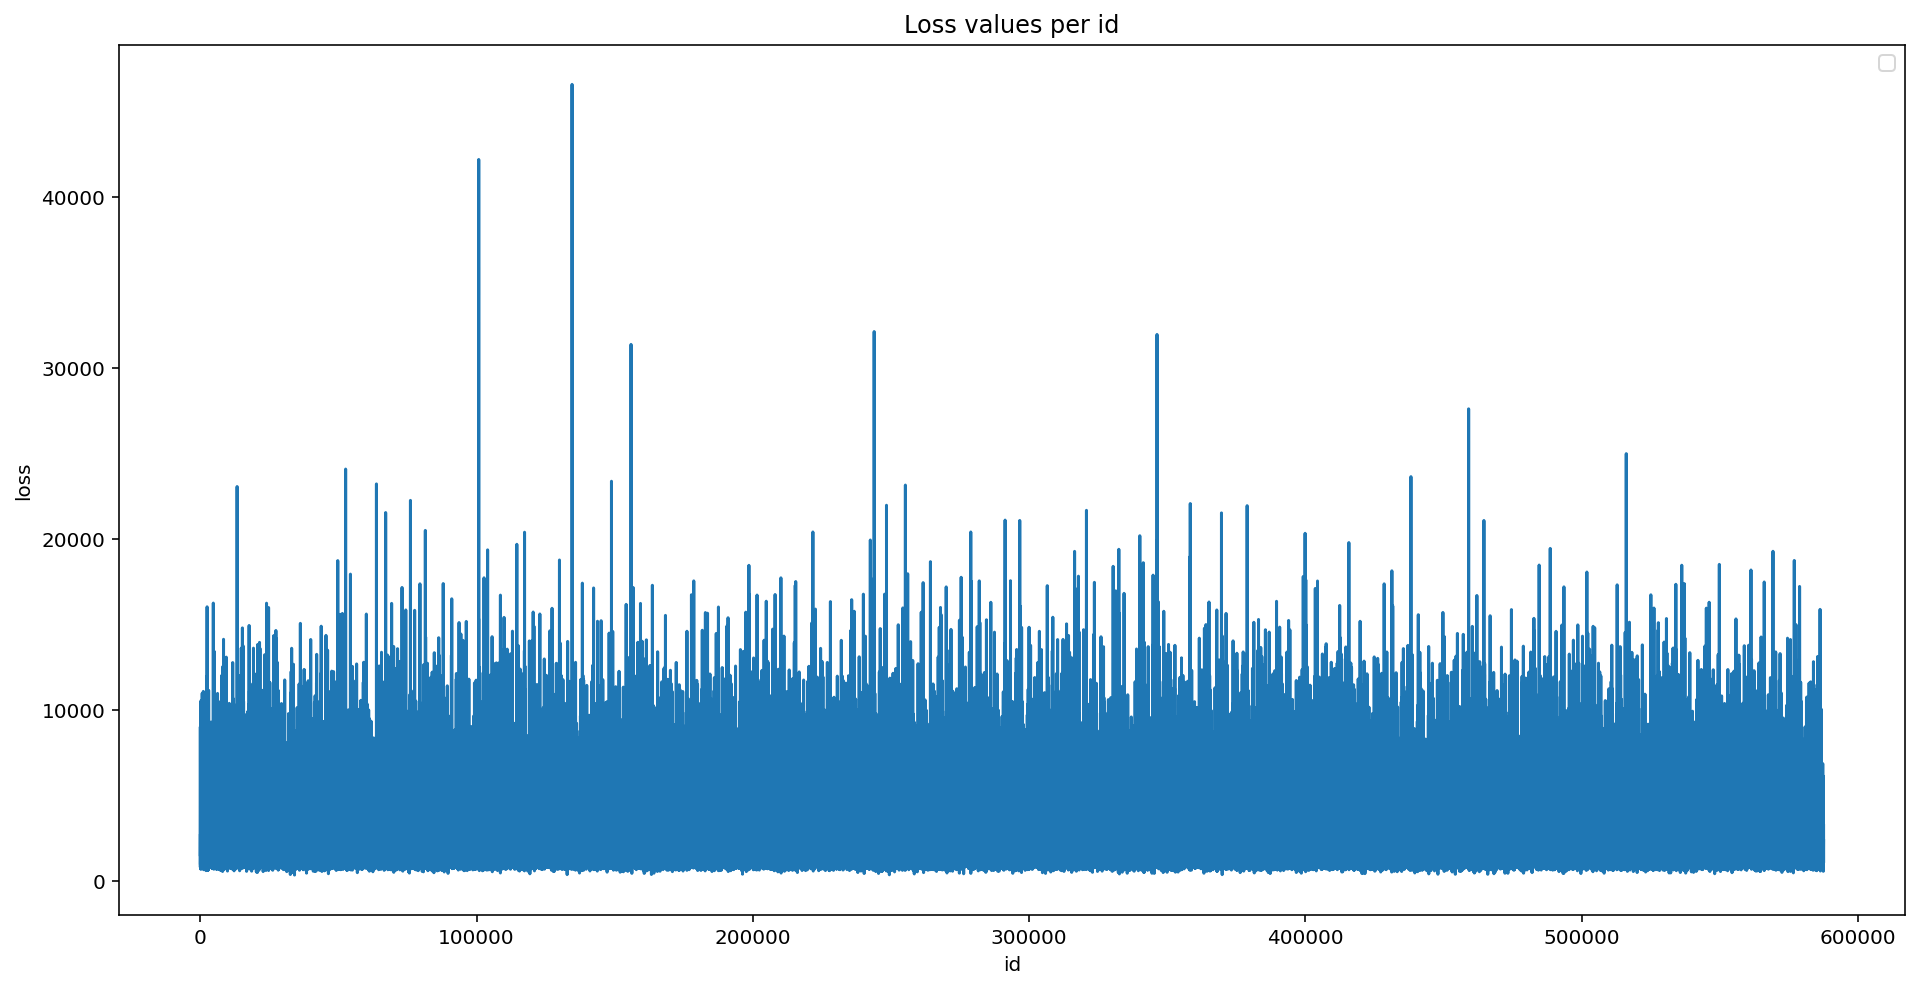

In [65]:
plt.figure(figsize=(16,8))
plt.plot(test['id'],test['loss'])
print('test[\'id\']个数:',len(test['id']))
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show()